In [ ]:
!pip install backtrader

In [ ]:
!pip install --upgrade yfinance

## Imports

In [ ]:
import backtrader as bt
from backtrader import plot
import time
from IPython.display import Image

import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta

import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import keras
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.models import Sequential
from keras.utils import Sequence
from keras.utils import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dense, Dropout, BatchNormalization, Lambda #,Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback


import os
import joblib
from PIL import Image


## Data Gathering

In [ ]:
def tickers2dfs(tickers, end_date="2025-04-01"):
    stock_data_arr = []
    total_rows = 0  # Counter for total number of rows

    for ticker in tickers:
        # Fetch data from the oldest available date
        stock_data = yf.download(ticker, end=end_date)

        if stock_data.empty:
            print(f"Warning: No data found for {ticker}")
            continue

        # Handling MultiIndex columns
        if isinstance(stock_data.columns, pd.MultiIndex):
            stock_data.columns = [' '.join(col).strip() for col in stock_data.columns]

        # Renaming columns to remove ticker names
        rename_mapping = {col: col.split()[0] for col in stock_data.columns}
        stock_data.rename(columns=rename_mapping, inplace=True)

        # Formatting index
        stock_data.index = pd.to_datetime(stock_data.index).strftime("%Y-%m-%d 00:00:00")

        # Store DataFrame and update total row count
        stock_data_arr.append(stock_data.reset_index())
        total_rows += len(stock_data)

    print(f"\n Total number of rows across all tickers: {total_rows}")

    return stock_data_arr

# Example usage:
tickers = [
    "AAPL",
    "MSFT",
    "GOOG",
    "NVDA",
    "TSLA",
    "META",
    "INTC",
    "CSCO",
    "CRM",
    "ORCL",
    "IBM",
    "AVGO",
    "QCOM"
]
data = tickers2dfs(tickers)

print(len(tickers))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 Total number of rows across all tickers: 103228
13


In [ ]:
print(data[0])

                      Date       Close        High         Low        Open  \
0      1980-12-12 00:00:00    0.098726    0.099155    0.098726    0.098726   
1      1980-12-15 00:00:00    0.093575    0.094005    0.093575    0.094005   
2      1980-12-16 00:00:00    0.086707    0.087136    0.086707    0.087136   
3      1980-12-17 00:00:00    0.088853    0.089282    0.088853    0.088853   
4      1980-12-18 00:00:00    0.091429    0.091858    0.091429    0.091429   
...                    ...         ...         ...         ...         ...   
11160  2025-03-25 00:00:00  223.750000  224.100006  220.080002  220.770004   
11161  2025-03-26 00:00:00  221.529999  225.020004  220.470001  223.509995   
11162  2025-03-27 00:00:00  223.850006  224.990005  220.559998  221.389999   
11163  2025-03-28 00:00:00  217.899994  223.809998  217.679993  221.669998   
11164  2025-03-31 00:00:00  222.130005  225.619995  216.229996  217.009995   

          Volume  
0      469033600  
1      175884800  
2     

## Generator

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, data_list, num_past_days, percentage_change, num_future_days=3, batch_size=32):
        self.data_list = data_list
        self.num_past_days = num_past_days
        self.num_future_days = num_future_days
        self.percentage_change = percentage_change
        self.batch_size = batch_size

        # Convert all dataframes to numpy arrays
        self.features_list = [
            df[['Open', 'High', 'Low', 'Close', 'Volume']].to_numpy() for df in data_list
        ]
        self.data_array = np.concatenate(self.features_list, axis=0)

        # Generate all valid sequences and labels in one place
        self.X, self.y, self.full_seqs = self.create_sequences_and_labels()

        # Group indices by class
        self.class_indices = self.get_class_indices()

    def create_sequences_and_labels(self):
        """
        Generates valid sequences (X) and corresponding labels (y).
        """
        X, y, full_seqs, unnormalized_seqs = [], [], [], []
        total_potential = len(self.data_array) - self.num_past_days - self.num_future_days
        skipped = 0

        for i in range(len(self.data_array) - self.num_past_days - self.num_future_days):
            seq = self.data_array[i:i + self.num_past_days + self.num_future_days].copy()
            unnormalized_seq = seq.copy()
            # Normalize
            seq = seq / np.max(seq, axis=0)

            # Compute label for this sequence
            prev_day_close = seq[self.num_past_days - 1, 3]  # Close price at last past day
            future_closes = seq[self.num_past_days:, 3]  # Future closing prices

            if prev_day_close == 0 or np.any(future_closes == 0):
                skipped += 1
                continue  # Skip invalid sequences

            avg_future_close = np.mean(future_closes)
            percentage_change = ((avg_future_close - prev_day_close) / prev_day_close) * 100

            if percentage_change >= self.percentage_change:
                label = 2  # BUY
            elif percentage_change <= -self.percentage_change:
                label = 0  # SELL
            else:
                label = 1  # HOLD

            # Store past data and corresponding label
            X.append(seq[:self.num_past_days])  # Only past days go into X
            y.append(label)
            full_seqs.append(seq)  # Store full normalized sequence
            unnormalized_seqs.append(unnormalized_seq)  # Store full unnormalized sequence

        return np.array(X), np.array(y), np.array(full_seqs)


    def get_class_indices(self):
        """ Stores indices for each class separately. """
        class_indices = defaultdict(list)
        for i, label in enumerate(self.y):
            class_indices[int(label)].append(i)
        return class_indices

    def __len__(self):
        min_samples = min(len(v) for v in self.class_indices.values())
        num_batches = (min_samples * 3) // self.batch_size  # Ensure class balance
        return max(1, num_batches)

    def __getitem__(self, index):
        """Generate a balanced batch"""
        samples_per_class = self.batch_size // 3  # Equal samples from each class

        X_batch, y_batch, seq_batch, unnormalized_batch = [], [], [], []
        for class_label in [0, 1, 2]:  # SELL, HOLD, BUY
            class_samples = np.random.choice(
                self.class_indices[class_label],
                size=samples_per_class,
                replace=False  # Oversampling if needed
            )

            for i in class_samples:
                X_batch.append(self.X[i])
                y_batch.append(class_label)

                # Retrieve the full past+future sequence for visualization
                seq_batch.append(self.full_seqs[i])  # Store full sequence
                #unnormalized_batch.append(self.unnormalized_seqs[i])

        # Shuffle batch to mix class samples
        temp = list(zip(X_batch, y_batch, seq_batch))
        np.random.shuffle(temp)
        X_batch, y_batch, seq_batch = zip(*temp)

        return np.array(X_batch), np.array(y_batch) #, np.array(seq_batch)


# Split data
test_size = 0.15
all_features = np.concatenate([df[['Open', 'High', 'Low', 'Close', 'Volume']].to_numpy() for df in data], axis=0)
split_index = int(len(all_features) * (1 - test_size))  # 85% train, 15% test

train_features = all_features[:split_index]
test_features = all_features[split_index:]
train_df = pd.DataFrame(train_features, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
test_df = pd.DataFrame(test_features, columns=['Open', 'High', 'Low', 'Close', 'Volume'])




# Create generators
percentage_change = 5
x_seq_len = 30
num_future_days = 10
train_gen = DataGenerator([train_df], batch_size=32, num_past_days=x_seq_len, percentage_change=percentage_change, num_future_days=num_future_days)
test_gen = DataGenerator([test_df], batch_size=32, num_past_days=x_seq_len, percentage_change=percentage_change, num_future_days=num_future_days)

# Check split results
print(f"Train samples: {len(train_gen)}, Test samples: {len(test_gen)}")

# Fetch first batch from train generator
#X_train, y_train , future_data_batch = train_gen[0]
X_train, y_train = train_gen[0]
print("Train batch shape:", X_train.shape, y_train.shape)

Train samples: 764, Test samples: 128
Train batch shape: (30, 30, 5) (30,)


Class Distribution

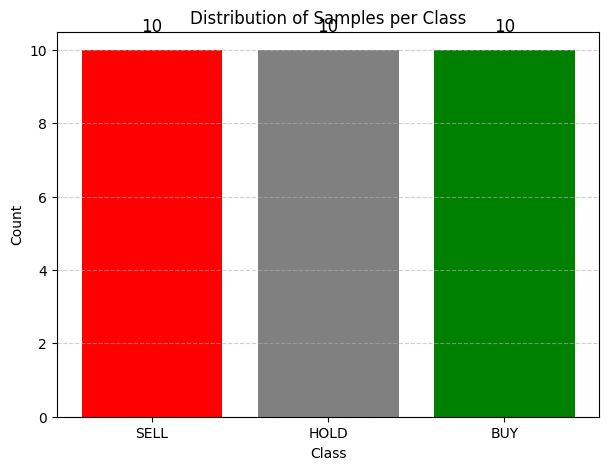

In [ ]:
def plot_class_distribution(data_generator, batch_index=0):
    """
    Plots the distribution of samples per class in a given batch.

    Parameters:
    - data_generator: Instance of DataGenerator
    - batch_index: Index of the batch to analyze
    """
    _, y_batch, _ = data_generator[batch_index]  # Get batch labels

    unique, counts = np.unique(y_batch, return_counts=True)  # Count occurrences
    label_map = {0: "SELL", 1: "HOLD", 2: "BUY"}

    # Convert labels to their textual representation
    labels = [label_map.get(label, "UNKNOWN") for label in unique]

    # Plot
    plt.figure(figsize=(7, 5))
    plt.bar(labels, counts, color=['red', 'gray', 'green'])
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Distribution of Samples per Class")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    # Display value on top of bars
    for i, count in enumerate(counts):
        plt.text(i, count + 0.5, str(count), ha="center", fontsize=12)

    plt.savefig("class_distribution.png", bbox_inches='tight', dpi=300)
    plt.show()

# Call the function
plot_class_distribution(train_gen, batch_index=0)

Batch Visualization Check

In [ ]:
def visualize_batch(data_generator, batch_index=0, num_samples=5, save_dir=None):
    """
    Visualizes a batch of sequences from the DataGenerator.

    Parameters:
    - data_generator: Instance of DataGenerator
    - batch_index: Index of the batch to visualize
    - num_samples: Number of samples to plot from the batch
    """
    X_batch, y_batch, seq_batch = data_generator[batch_index]  # Fetch batch

    num_samples = min(num_samples, len(X_batch))  # Limit to batch size

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    fig, axes = plt.subplots(num_samples, 1, figsize=(10, num_samples * 4), sharex=True)

    if num_samples == 1:
        axes = [axes]  # Ensure iterable for single sample case

    for i in range(num_samples):
        seq = seq_batch[i]  # Full sequence (past + future)
        past = X_batch[i]  # Past data
        future = seq[data_generator.num_past_days:]  # Future data
        label = y_batch[i]  # Assigned label

        prev_day_close = past[-1, 3]  # Last past close price
        avg_future_close = np.mean(future[:, 3])  # Average future close price

        percentage_change = ((avg_future_close - prev_day_close) / prev_day_close) * 100
        threshold = data_generator.percentage_change  # Get ±threshold

        print(f"Sample {i+1}:")
        print(f"  - prev_day_close: {prev_day_close}")
        print(f"  - avg_future_close: {avg_future_close}")
        print(f"  - percentage_change: {percentage_change:.2f}%")
        print(f"  - Future closes: {future[:, 3]}")
        print(f"  - Past closes: {past[:, 3]}")
        print("=" * 50)
                # Create individual figure for this sample
        if save_dir:
            fig_single, ax_single = plt.subplots(figsize=(10, 4))

            # Plot to individual figure
            ax_single.plot(range(len(past)), past[:, 3], label="Past Close", color="blue")
            ax_single.plot(range(len(past), len(seq)), future[:, 3], label="Future Close", color="orange")
            ax_single.axvline(x=len(past) - 1, color="red", linestyle="--", label="Prediction Start")
            ax_single.axhline(y=avg_future_close, color="green", linestyle="--", label="Avg Future Close")

            # Plot percentage change thresholds
            lower_bound = prev_day_close * (1 - threshold / 100)
            upper_bound = prev_day_close * (1 + threshold / 100)
            ax_single.fill_between(range(len(seq)), lower_bound, upper_bound,
                                 color='gray', alpha=0.2, label=f"±{threshold}% Threshold")

            # Set title and labels
            label_map = {0: "SELL", 1: "HOLD", 2: "BUY"}
            ax_single.set_title(f"Sample {i + 1}: Label = {label_map.get(label, 'UNKNOWN')} ({label}) | Δ = {percentage_change:.2f}%")
            ax_single.set_xlabel("Time Step")
            ax_single.legend()
            ax_single.grid()

            # Save individual plot
            filename = os.path.join(save_dir, f"sample_{batch_index}_{i}.png")
            fig_single.savefig(filename, bbox_inches='tight', dpi=300)
            plt.close(fig_single)  # Close the individual figure to free memory
            print(f"Saved individual plot to {filename}")

        # Plot to the main figure (original functionality)
        ax = axes[i]
        ax.plot(range(len(past)), past[:, 3], label="Past Close", color="blue")
        ax.plot(range(len(past), len(seq)), future[:, 3], label="Future Close", color="orange")
        ax.axvline(x=len(past) - 1, color="red", linestyle="--", label="Prediction Start")
        ax.axhline(y=avg_future_close, color="green", linestyle="--", label="Avg Future Close")

        lower_bound = prev_day_close * (1 - threshold / 100)
        upper_bound = prev_day_close * (1 + threshold / 100)
        ax.fill_between(range(len(seq)), lower_bound, upper_bound,
                       color='gray', alpha=0.2, label=f"±{threshold}% Threshold")

        label_map = {0: "SELL", 1: "HOLD", 2: "BUY"}
        ax.set_title(f"Sample {i + 1}: Label = {label_map.get(label, 'UNKNOWN')} ({label}) | Δ = {percentage_change:.2f}%")
        ax.legend()
        ax.grid()

    plt.xlabel("Time Step")

    # Save the combined plot if requested
    if save_dir:
        combined_filename = os.path.join(save_dir, f"batch_{batch_index}_combined.png")
        fig.savefig(combined_filename, bbox_inches='tight', dpi=300)
        print(f"Saved combined plot to {combined_filename}")

    plt.show()
    plt.close(fig)

# Call the visualization function
visualize_batch(train_gen, batch_index=0, num_samples=5, save_dir="unnormal")


ValueError: not enough values to unpack (expected 3, got 2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 30, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 30, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 15, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 15, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 7, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 7, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,219 (192.26 KB)

 Trainable params: 48,771 (190.51 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


760/764 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5463 - loss: 0.9159
Epoch 1: val_accuracy improved from -inf to 0.47891, saving model to best_model.h5


764/764 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5466 - loss: 0.9154 - val_accuracy: 0.4789 - val_loss: 0.9779
Epoch 2/20
760/764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6488 - loss: 0.7404
Epoch 2: val_accuracy improved from 0.47891 to 0.61432, saving model to best_model.h5


764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6489 - loss: 0.7402 - val_accuracy: 0.6143 - val_loss: 0.8997
Epoch 3/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6640 - loss: 0.7014
Epoch 3: val_accuracy did not improve from 0.61432
764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6640 - loss: 0.7014 - val_accuracy: 0.6003 - val_loss: 1.0172
Epoch 4/20
759/764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6770 - loss: 0.6707
Epoch 4: val_accuracy did not improve from 0.61432
764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6771 - loss: 0.6707 - val_accuracy: 0.5734 - val_loss: 1.3518
Epoch 5/20
758/764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6926 - loss: 0.6505
Epoch 5: val_accuracy did not improve from 0.61432
764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.6925 - loss: 0.6505 - val_accuracy: 0.4193 - val_loss: 2.4574
Epoch 6/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6973 - loss: 0.6439
Epoch 6: val_accuracy d

764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6981 - loss: 0.6412 - val_accuracy: 0.6286 - val_loss: 0.8197
Epoch 9/20
763/764 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6991 - loss: 0.6369
Epoch 9: val_accuracy did not improve from 0.62865
764/764 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6991 - loss: 0.6369 - val_accuracy: 0.4148 - val_loss: 1.9355
Epoch 10/20
762/764 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7028 - loss: 0.6331
Epoch 10: val_accuracy improved from 0.62865 to 0.64505, saving model to best_model.h5


764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7028 - loss: 0.6331 - val_accuracy: 0.6451 - val_loss: 0.7847
Epoch 11/20
764/764 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7124 - loss: 0.6154
Epoch 11: val_accuracy improved from 0.64505 to 0.65208, saving model to best_model.h5


764/764 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7124 - loss: 0.6154 - val_accuracy: 0.6521 - val_loss: 0.7250
Epoch 12/20
760/764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7121 - loss: 0.6242
Epoch 12: val_accuracy did not improve from 0.65208
764/764 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7121 - loss: 0.6242 - val_accuracy: 0.4805 - val_loss: 1.3116
Epoch 13/20
762/764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7120 - loss: 0.6221
Epoch 13: val_accuracy improved from 0.65208 to 0.66641, saving model to best_model.h5


764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7119 - loss: 0.6222 - val_accuracy: 0.6664 - val_loss: 0.7068
Epoch 14/20
758/764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7123 - loss: 0.6133
Epoch 14: val_accuracy did not improve from 0.66641
764/764 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7123 - loss: 0.6133 - val_accuracy: 0.5742 - val_loss: 0.8725
Epoch 15/20
762/764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7142 - loss: 0.6184
Epoch 15: val_accuracy did not improve from 0.66641
764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7142 - loss: 0.6184 - val_accuracy: 0.6081 - val_loss: 0.8585
Epoch 16/20
758/764 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7117 - loss: 0.6158
Epoch 16: val_accuracy did not improve from 0.66641
764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7117 - loss: 0.6158 - val_accuracy: 0.5792 - val_loss: 0.9142
Epoch 17/20
762/764 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7253 - loss: 0.6006
Epoch 17: val_ac

764/764 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7186 - loss: 0.6103 - val_accuracy: 0.6729 - val_loss: 0.7026


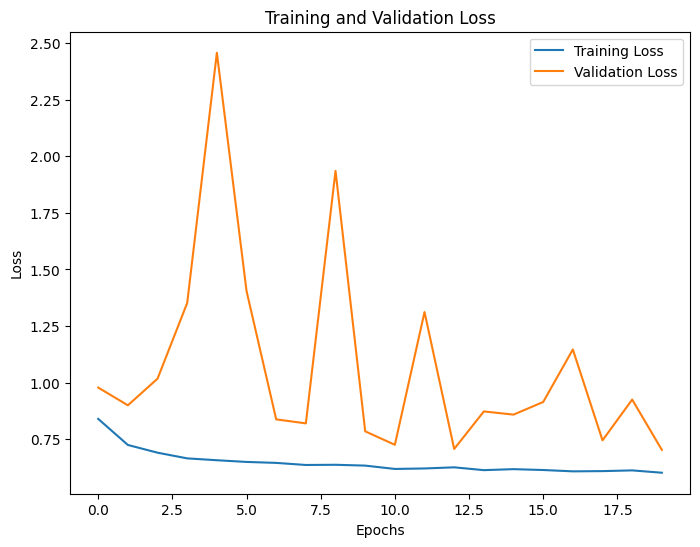

In [ ]:
def build_cnn_model(input_shape, num_classes=3, window_size=3):
    model = Sequential([

        Conv1D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.2),

        Conv1D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        Conv1D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAveragePooling1D(),

        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



# Build model using input shape from generator
input_shape = (x_seq_len, 5)  # (sequence_length=5, features=5)
#window_size = 3
cnn_model = build_cnn_model(input_shape) #, window_size)

# Model Summary
cnn_model.summary()


# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',         # File path to save the model
    monitor='val_accuracy',      # Monitor validation loss
    save_best_only=True,     # Only save the model if it improves
    mode='max',              # We want to minimize the validation loss
    verbose=1                # Print when the model is saved
)

# Train the model with the ModelCheckpoint callback
history = cnn_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=20,
    verbose=1,
    callbacks=[checkpoint_callback]  # Include the callback
)

# After training, you can load the best model
best_model = tensorflow.keras.models.load_model('best_model.h5')

# Extract the loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


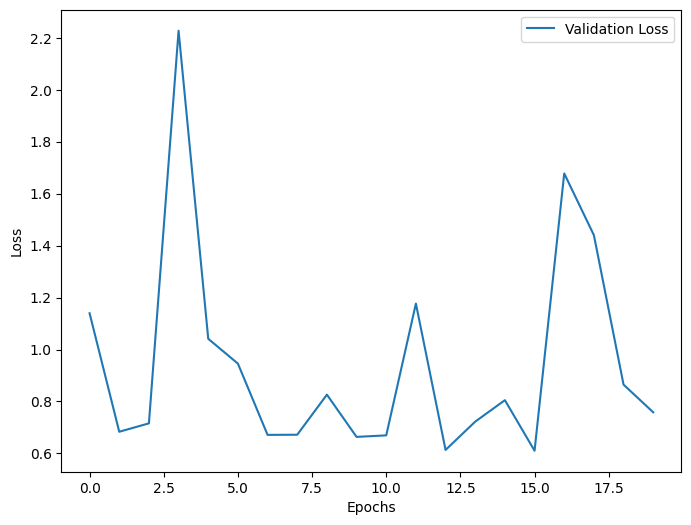

In [ ]:

val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluation

y_true shape: (3840,)
y_pred_classes shape: (3840,)


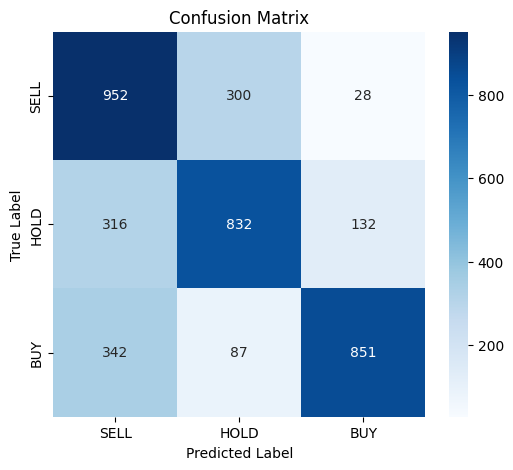

Classification Report:
               precision    recall  f1-score   support

        SELL       0.59      0.74      0.66      1280
        HOLD       0.68      0.65      0.67      1280
         BUY       0.84      0.66      0.74      1280

    accuracy                           0.69      3840
   macro avg       0.71      0.69      0.69      3840
weighted avg       0.71      0.69      0.69      3840



In [ ]:
#model = joblib.load('best_model.h5')
#y_pred = model.predict(X_test)
# Collect predictions and true labels while ensuring shape consistency
y_pred_list, y_true_list = [], []

for i in range(len(test_gen)):
    X_batch, y_batch = test_gen[i]  # Get batch data
    batch_preds = best_model.predict(X_batch, verbose=0)  # Predict batch-wise
    y_pred_list.append(batch_preds)
    y_true_list.append(y_batch)

# Convert lists to arrays
y_pred = np.concatenate(y_pred_list)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax to class labels
y_true = np.concatenate(y_true_list)

print("y_true shape:", y_true.shape)
print("y_pred_classes shape:", y_pred_classes.shape)

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['SELL', 'HOLD', 'BUY'], yticklabels=['SELL', 'HOLD', 'BUY'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=['SELL', 'HOLD', 'BUY']))

In [ ]:
best_model = tensorflow.keras.models.load_model('best_model.h5')
img_path_model = "model_plot.jpg"
img = keras.utils.plot_model(best_model, to_file=img_path_model)

In [ ]:
class CNNStrategy(bt.Strategy):
    params = (
        ('portfolio_size', 0),
        ('investment_percentage', 0.01),  # 1% of portfolio per trade
        ('model', None),
        ('sequence_length', 7),
        ('future_days', 3),
        ('threshold', 0.6),        # Probability threshold for BUY/SELL
    )

    def __init__(self):
        self.total_invested = 0
        self.holdings = []  # List of (entry_price, shares)
        self.data_buffer = []
        self.order = None

        self.portfolio_values = []  # To store portfolio values
        self.dates = []  # To store dates

        self.shares = 0
        self.initial_cash = self.broker.getcash()
        self.portfolio_value = self.initial_cash + self.params.portfolio_size

        # Data references for convenience
        self.data_close = self.datas[0].close
        self.data_open  = self.datas[0].open
        self.data_high  = self.datas[0].high
        self.data_low   = self.datas[0].low
        self.data_volume= self.datas[0].volume

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')

    def notify_order(self, order):
        if order.status in [order.Completed]:
            self.order = None

    def next(self):
        if self.order:
            return

        # Add current data to buffer
        current_data = np.array([
            self.data_open[0],
            self.data_high[0],
            self.data_low[0],
            self.data_close[0],
            self.data_volume[0]
        ])
        self.data_buffer.append(current_data)

        self.portfolio_values.append(self.broker.getvalue())
        self.dates.append(self.data.datetime.date())

        if len(self.data_buffer) > self.params.sequence_length + self.params.future_days:
            self.data_buffer.pop(0)

        # Make prediction
        if len(self.data_buffer) >= self.params.sequence_length + self.params.future_days:
            seq = np.array(self.data_buffer[-(self.params.sequence_length + self.params.future_days):])

            with np.errstate(divide='ignore', invalid='ignore'):
                seq = seq / np.max(seq, axis=0)
                seq = np.nan_to_num(seq, nan=0.0, posinf=0.0, neginf=0.0)

            X = seq[:self.params.sequence_length].reshape(1, self.params.sequence_length, 5)
            prediction = self.params.model.predict(X, verbose=0)[0]  # e.g., [0.1, 0.3, 0.6]
            p_sell, p_hold, p_buy = prediction

            self.log(f"Prediction probs -> SELL: {p_sell:.3f}, HOLD: {p_hold:.3f}, BUY: {p_buy:.3f}")

            # Signal thresholds
            buy_signal = p_buy > self.params.threshold
            sell_signal = p_sell > self.params.threshold

            if buy_signal:
                amount = self.params.portfolio_size * self.params.investment_percentage
                cash = self.broker.getcash()
                if amount > cash:
                    amount = cash

                if amount > 0:
                    shares = amount / self.data_close[0]
                    self.order = self.buy(size=shares)
                    self.shares += shares
                    self.holdings.append((self.data_close[0], shares))
                    self.total_invested += amount
                    self.initial_cash -= amount
                    self.portfolio_value = self.broker.getvalue()
                    self.log(f"BUY (P={p_buy:.2f}) at {self.data_close[0]:.2f}, Shares: {shares:.6f}, Amount: ${amount:.2f}")


            elif sell_signal and self.position:
                total_shares = self.position.size
                if total_shares > 0:
                    self.order = self.sell(size=total_shares)
                    total_cost = sum(price * shares for price, shares in self.holdings)
                    sale_value = self.data_close[0] * total_shares
                    profit = sale_value - total_cost
                    self.log(f"SELL (P={p_sell:.2f}) at {self.data_close[0]:.2f}, Shares: {total_shares:.6f}, Profit: ${profit:.2f}")
                    self.total_invested -= total_cost
                    self.holdings = []
                    self.shares = 0
                    self.initial_cash = self.broker.getcash()
                    self.portfolio_value = self.broker.getvalue()

    def stop(self):
        portfolio_value = self.broker.getvalue()
        profit = portfolio_value - self.total_invested
        roi = (profit / self.total_invested) * 100 if self.total_invested > 0 else 0

        print('\n=== Strategy Summary ===')
        print(f'Total Invested: ${self.total_invested:.2f}')
        print(f'Portfolio Value: ${portfolio_value:.2f}')
        print(f'Total Profit: ${profit:.2f}')
        print(f'ROI: {roi:.4f}%')

In [ ]:
def prepare_data_for_backtrader(ticker, start_date, end_date):
    """
    Downloads historical data using yfinance and formats it for Backtrader.
    """
    df = yf.download(ticker, start=start_date, end=end_date)

    if df.empty:
        raise ValueError("Downloaded dataframe is empty. Check ticker or date range.")

    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = df[col].astype('float64')

    return df

def backtest_strategy(ticker, start_date, end_date, model, initial_cash=10000,investment_percentage=0.07):
    """
    Runs a backtest using the CNNStrategy on historical stock data.
    """
    # Prepare the data
    df = prepare_data_for_backtrader(ticker, start_date, end_date)

    # Initialize Cerebro engine
    cerebro = bt.Cerebro()

    # Add data feed
    data = bt.feeds.PandasData(
        dataname=df,
        datetime='date',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None
    )
    cerebro.adddata(data)

    # Add strategy
    cerebro.addstrategy(
        CNNStrategy,
        portfolio_size=initial_cash,
        investment_percentage=investment_percentage,
        model=model,
        sequence_length=30,
        future_days=10
    )

    # Set broker parameters
    cerebro.broker.setcash(initial_cash)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Run backtest
    print(f'\nStarting Portfolio Value: ${cerebro.broker.getvalue():.2f}')
    results = cerebro.run()
    strategy = results[0]
    final_value = cerebro.broker.getvalue()


    # Print performance metrics
    print('\n=== Backtest Results ===')
    print(f'Final Portfolio Value: ${final_value:.2f}')
    print(f'Total Return: {strategy.analyzers.returns.get_analysis()["rtot"] * 100:.2f}%')
    print(f'Sharpe Ratio: {strategy.analyzers.sharpe.get_analysis().get("sharperatio", "N/A")}')
    print(f'Max Drawdown: {strategy.analyzers.drawdown.get_analysis()["max"]["drawdown"]:.2f}%')
    print(f'Difference: ${final_value - initial_cash:.2f}')


   # Generate the plots
    figs = cerebro.plot(style='candlestick', volume=True, subplot=True, figsize=(32, 16))

    # Extract and save only the top subplot (portfolio value and cash)
    if figs and len(figs[0]) > 0:
        fig = figs[0][0]
        axes = fig.get_axes()

        if len(axes) > 0:
            top_ax = axes[0]  # Usually the top subplot (portfolio value)
            fig_top = plt.figure(figsize=(10, 6))
            ax_new = fig_top.add_subplot(111)

            # Copy all lines from original top_ax to new figure
            for line in top_ax.get_lines():
                ax_new.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())

            ax_new.set_title(top_ax.get_title())
            ax_new.set_xlabel(top_ax.get_xlabel())
            ax_new.set_ylabel(top_ax.get_ylabel())
            ax_new.legend()

            # Save to file
            top_plot_path = "portfolio_top_subplot_only4.png"
            fig_top.tight_layout()
            fig_top.savefig(top_plot_path, dpi=150)
            plt.close(fig_top)  # Close the new figure
            plt.close(fig)      # Close the main cerebro plot
            print(f"Saved top (portfolio value) subplot to: {top_plot_path}")
        else:
            print("No axes found in the figure.")
    else:
        print("No plots were generated.")

In [ ]:
model = tensorflow.keras.models.load_model('best_model.h5')

img_path_cnn = "CNNStrategy_plot.png"

# Set parameters
ticker = 'AMZN'  # Example ticker
start_date = '2007-10-01'
end_date = '2009-06-30'
initial_cash = 10000

# Run backtest
backtest_strategy(ticker, start_date, end_date, model, initial_cash=10000, investment_percentage=0.02)

[*********************100%***********************]  1 of 1 completed



Starting Portfolio Value: $10000.00
2007-11-26 Prediction probs -> SELL: 0.429, HOLD: 0.203, BUY: 0.368
2007-11-27 Prediction probs -> SELL: 0.403, HOLD: 0.206, BUY: 0.391
2007-11-28 Prediction probs -> SELL: 0.389, HOLD: 0.221, BUY: 0.390
2007-11-29 Prediction probs -> SELL: 0.375, HOLD: 0.260, BUY: 0.365
2007-11-30 Prediction probs -> SELL: 0.435, HOLD: 0.205, BUY: 0.361
2007-12-03 Prediction probs -> SELL: 0.417, HOLD: 0.218, BUY: 0.364
2007-12-04 Prediction probs -> SELL: 0.397, HOLD: 0.211, BUY: 0.392
2007-12-05 Prediction probs -> SELL: 0.394, HOLD: 0.212, BUY: 0.395
2007-12-06 Prediction probs -> SELL: 0.421, HOLD: 0.210, BUY: 0.368
2007-12-07 Prediction probs -> SELL: 0.424, HOLD: 0.229, BUY: 0.347
2007-12-10 Prediction probs -> SELL: 0.403, HOLD: 0.235, BUY: 0.362
2007-12-11 Prediction probs -> SELL: 0.338, HOLD: 0.246, BUY: 0.416
2007-12-12 Prediction probs -> SELL: 0.443, HOLD: 0.270, BUY: 0.287
2007-12-13 Prediction probs -> SELL: 0.438, HOLD: 0.298, BUY: 0.265
2007-12-14 

<IPython.core.display.Javascript object>

Saved top (portfolio value) subplot to: portfolio_top_subplot_only.png


In [ ]:
model = tensorflow.keras.models.load_model('best_model.h5')

img_path_cnn = "CNNStrategy_plot.png"

# Set parameters
ticker = 'AMZN'  # Example ticker
start_date = '2020-01-01'
end_date = '2020-09-01'
initial_cash = 10000



# Run backtest
backtest_strategy(ticker, start_date, end_date, model, initial_cash=10000, investment_percentage=0.05)

[*********************100%***********************]  1 of 1 completed



Starting Portfolio Value: $10000.00
2020-02-28 Prediction probs -> SELL: 0.435, HOLD: 0.565, BUY: 0.000
2020-03-02 Prediction probs -> SELL: 0.472, HOLD: 0.527, BUY: 0.001
2020-03-03 Prediction probs -> SELL: 0.423, HOLD: 0.577, BUY: 0.000
2020-03-04 Prediction probs -> SELL: 0.475, HOLD: 0.524, BUY: 0.000
2020-03-05 Prediction probs -> SELL: 0.420, HOLD: 0.580, BUY: 0.000
2020-03-06 Prediction probs -> SELL: 0.506, HOLD: 0.486, BUY: 0.008
2020-03-09 Prediction probs -> SELL: 0.444, HOLD: 0.398, BUY: 0.159
2020-03-10 Prediction probs -> SELL: 0.403, HOLD: 0.323, BUY: 0.274
2020-03-11 Prediction probs -> SELL: 0.410, HOLD: 0.331, BUY: 0.258
2020-03-12 Prediction probs -> SELL: 0.425, HOLD: 0.272, BUY: 0.303
2020-03-13 Prediction probs -> SELL: 0.454, HOLD: 0.268, BUY: 0.278
2020-03-16 Prediction probs -> SELL: 0.487, HOLD: 0.279, BUY: 0.233
2020-03-17 Prediction probs -> SELL: 0.469, HOLD: 0.282, BUY: 0.250
2020-03-18 Prediction probs -> SELL: 0.517, HOLD: 0.264, BUY: 0.219
2020-03-19 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved top (portfolio value) subplot to: portfolio_top_subplot_only2.png


In [ ]:
model = tensorflow.keras.models.load_model('best_model.h5')

img_path_cnn = "CNNStrategy_plot.png"

# Set parameters
ticker = 'AMZN'  # Example ticker
start_date = '2012-01-01'
end_date = '2013-12-31'
initial_cash = 10000

# Run backtest
backtest_strategy(ticker, start_date, end_date, model, initial_cash=10000, investment_percentage=0.03)

[*********************100%***********************]  1 of 1 completed



Starting Portfolio Value: $10000.00
2012-02-29 Prediction probs -> SELL: 0.546, HOLD: 0.453, BUY: 0.000
2012-03-01 Prediction probs -> SELL: 0.502, HOLD: 0.483, BUY: 0.015
2012-03-02 Prediction probs -> SELL: 0.392, HOLD: 0.372, BUY: 0.236
2012-03-05 Prediction probs -> SELL: 0.457, HOLD: 0.442, BUY: 0.100
2012-03-06 Prediction probs -> SELL: 0.390, HOLD: 0.515, BUY: 0.094
2012-03-07 Prediction probs -> SELL: 0.367, HOLD: 0.510, BUY: 0.123
2012-03-08 Prediction probs -> SELL: 0.357, HOLD: 0.368, BUY: 0.276
2012-03-09 Prediction probs -> SELL: 0.417, HOLD: 0.341, BUY: 0.242
2012-03-12 Prediction probs -> SELL: 0.364, HOLD: 0.379, BUY: 0.257
2012-03-13 Prediction probs -> SELL: 0.462, HOLD: 0.493, BUY: 0.045
2012-03-14 Prediction probs -> SELL: 0.335, HOLD: 0.440, BUY: 0.225
2012-03-15 Prediction probs -> SELL: 0.382, HOLD: 0.404, BUY: 0.215
2012-03-16 Prediction probs -> SELL: 0.317, HOLD: 0.498, BUY: 0.185
2012-03-19 Prediction probs -> SELL: 0.344, HOLD: 0.500, BUY: 0.156
2012-03-20 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved top (portfolio value) subplot to: portfolio_top_subplot_only3.png


In [ ]:
model = tensorflow.keras.models.load_model('best_model.h5')

img_path_cnn = "CNNStrategy_plot.png"

# Set parameters
ticker = 'AMZN'  # Example ticker
start_date = '2022-09-01'
end_date = '2024-04-01'
initial_cash = 10000

# Run backtest
backtest_strategy(ticker, start_date, end_date, model, initial_cash=10000, investment_percentage=0.04)

[*********************100%***********************]  1 of 1 completed



Starting Portfolio Value: $10000.00
2022-10-27 Prediction probs -> SELL: 0.368, HOLD: 0.131, BUY: 0.501
2022-10-28 Prediction probs -> SELL: 0.694, HOLD: 0.074, BUY: 0.232
2022-10-31 Prediction probs -> SELL: 0.671, HOLD: 0.085, BUY: 0.244
2022-11-01 Prediction probs -> SELL: 0.669, HOLD: 0.086, BUY: 0.244
2022-11-02 Prediction probs -> SELL: 0.709, HOLD: 0.075, BUY: 0.216
2022-11-03 Prediction probs -> SELL: 0.701, HOLD: 0.076, BUY: 0.223
2022-11-04 Prediction probs -> SELL: 0.687, HOLD: 0.072, BUY: 0.241
2022-11-07 Prediction probs -> SELL: 0.782, HOLD: 0.155, BUY: 0.063
2022-11-08 Prediction probs -> SELL: 0.829, HOLD: 0.148, BUY: 0.024
2022-11-09 Prediction probs -> SELL: 0.724, HOLD: 0.139, BUY: 0.137
2022-11-10 Prediction probs -> SELL: 0.739, HOLD: 0.089, BUY: 0.172
2022-11-11 Prediction probs -> SELL: 0.456, HOLD: 0.171, BUY: 0.373
2022-11-14 Prediction probs -> SELL: 0.545, HOLD: 0.163, BUY: 0.292
2022-11-15 Prediction probs -> SELL: 0.379, HOLD: 0.265, BUY: 0.357
2022-11-16 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved top (portfolio value) subplot to: portfolio_top_subplot_only4.png


In [ ]:
class DCAStrategy(bt.Strategy):
    params = (
        ('investment_amount', 100),  # Fixed amount to invest each period
        ('investment_interval', 30),  # Days between investments
        ('portfolio_size', 100000),   # Starting portfolio value
    )

    def __init__(self):
        self.counter = 0
        self.total_invested = 0
        self.next_investment_date = self.data.datetime.date(1)  # First investment on first day

    def next(self):
        current_date = self.data.datetime.date()

        # Check if it's time to invest
        if current_date >= self.next_investment_date:
            # Calculate how many shares we can buy
            amount = min(self.params.investment_amount, self.broker.getcash())
            if amount > 0:
                size = amount / self.data.close[0]
                self.buy(size=size)
                self.total_invested += amount
                print(f'Invested ${amount:.2f} at {current_date}, Price: ${self.data.close[0]:.2f}')

            # Schedule next investment
            self.next_investment_date = current_date + pd.Timedelta(days=self.params.investment_interval)
            self.counter = 0

        self.counter += 1

    def stop(self):
        # Print final results
        portfolio_value = self.broker.getvalue()
        profit = portfolio_value - self.total_invested
        roi = (profit / self.total_invested) * 100 if self.total_invested > 0 else 0

        print('\n=== DCA Strategy Results ===')
        print(f'Total Invested: ${self.total_invested:.2f}')
        print(f'Portfolio Value: ${portfolio_value:.2f}')
        print(f'Profit: ${profit:.2f}')
        print(f'ROI: {roi:.2f}%')

def prepare_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    return df

def run_backtest(strategy_class, ticker, start_date, end_date, **kwargs):
    # Prepare data
    df = prepare_data(ticker, start_date, end_date)

    # Create Cerebro engine
    cerebro = bt.Cerebro()

    # Add data
    data = bt.feeds.PandasData(
        dataname=df,
        datetime='date',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None
    )
    cerebro.adddata(data)

    # Add strategy
    cerebro.addstrategy(strategy_class, **kwargs)

    # Set initial cash
    initial_cash = kwargs.get('portfolio_size', 10000)
    cerebro.broker.setcash(initial_cash)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    # Run backtest
    results = cerebro.run()
    strat = results[0]
    final_value = cerebro.broker.getvalue()
    # Print results
    print(f'\n=== {strategy_class.__name__} Results ===')
    print(f'Final Portfolio Value: ${cerebro.broker.getvalue():.2f}')
    print(f'Total Return: {strat.analyzers.returns.get_analysis()["rtot"]:.2f}%')
    #print(f'Sharpe Ratio: {strat.analyzers.sharpe.get_analysis().get("sharperatio", "N/A")}')
    print(f'Max Drawdown: {strat.analyzers.drawdown.get_analysis()["max"]["drawdown"]:.2f}%')
    print(f'Difference: ${final_value - initial_cash:.2f}')

    return cerebro

In [ ]:
ticker = 'AMZN'
start_date = '2007-10-01'
end_date = '2009-06-30'
initial_cash = 10000

# Run DCA Strategy
print("Running DCA Strategy...")
dca_cerebro = run_backtest(
    DCAStrategy,
    ticker,
    start_date,
    end_date,
    investment_amount=200,      # Invest $200 each time
    investment_interval=10,
    portfolio_size=initial_cash
)

# Generate the full plot with all subplots
figs = dca_cerebro.plot(style='candlestick', volume=True, subplot=True, figsize=(16, 12))

# Save only the top subplot (portfolio value)
if figs and len(figs[0]) > 0:
    fig = figs[0][0]
    axes = fig.get_axes()

    if len(axes) > 0:
        top_ax = axes[0]  # First subplot (usually cash & portfolio value)
        fig_top = plt.figure(figsize=(10, 6))
        ax_new = fig_top.add_subplot(111)

        for line in top_ax.get_lines():
            ax_new.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())

        ax_new.set_title(top_ax.get_title())
        ax_new.set_xlabel(top_ax.get_xlabel())
        ax_new.set_ylabel(top_ax.get_ylabel())
        ax_new.legend()

        # Save the extracted subplot
        top_img_path = "dca_top_subplot_only.png"
        fig_top.tight_layout()
        fig_top.savefig(top_img_path, dpi=150)
        plt.close(fig_top)
        plt.close(fig)
        print(f"Saved top (portfolio value) subplot to: {top_img_path}")
    else:
        print("No axes found in the figure.")
else:
    print("No plots were generated.")

[*********************100%***********************]  1 of 1 completed

Running DCA Strategy...
Invested $200.00 at 2007-10-01, Price: $4.67
Invested $200.00 at 2007-10-11, Price: $4.47
Invested $200.00 at 2007-10-22, Price: $4.56
Invested $200.00 at 2007-11-01, Price: $4.38
Invested $200.00 at 2007-11-12, Price: $3.85
Invested $200.00 at 2007-11-23, Price: $4.07
Invested $200.00 at 2007-12-03, Price: $4.55
Invested $200.00 at 2007-12-13, Price: $4.62
Invested $200.00 at 2007-12-24, Price: $4.55
Invested $200.00 at 2008-01-03, Price: $4.76
Invested $200.00 at 2008-01-14, Price: $4.14
Invested $200.00 at 2008-01-24, Price: $3.88
Invested $200.00 at 2008-02-04, Price: $3.70
Invested $200.00 at 2008-02-14, Price: $3.79
Invested $200.00 at 2008-02-25, Price: $3.66
Invested $200.00 at 2008-03-06, Price: $3.14
Invested $200.00 at 2008-03-17, Price: $3.33
Invested $200.00 at 2008-03-27, Price: $3.54
Invested $200.00 at 2008-04-07, Price: $3.85
Invested $200.00 at 2008-04-17, Price: $3.70
Invested $200.00 at 2008-04-28, Price: $4.10
Invested $200.00 at 2008-05-08,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved top (portfolio value) subplot to: dca_top_subplot_only.png


In [ ]:
ticker = 'AMZN'  # Example ticker
start_date = '2020-01-01'
end_date = '2020-09-01'
initial_cash = 10000

# Run DCA Strategy
# Run DCA Strategy
print("Running DCA Strategy...")
dca_cerebro = run_backtest(
    DCAStrategy,
    ticker,
    start_date,
    end_date,
    investment_amount=500,      # Invest $300 each time
    investment_interval=10,
    portfolio_size=initial_cash
)
# Generate the full plot with all subplots
figs = dca_cerebro.plot(style='candlestick', volume=True, subplot=True, figsize=(16, 12))

# Save only the top subplot (portfolio value)
if figs and len(figs[0]) > 0:
    fig = figs[0][0]
    axes = fig.get_axes()

    if len(axes) > 0:
        top_ax = axes[0]  # First subplot (usually cash & portfolio value)
        fig_top = plt.figure(figsize=(10, 6))
        ax_new = fig_top.add_subplot(111)

        for line in top_ax.get_lines():
            ax_new.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())

        ax_new.set_title(top_ax.get_title())
        ax_new.set_xlabel(top_ax.get_xlabel())
        ax_new.set_ylabel(top_ax.get_ylabel())
        ax_new.legend()

        # Save the extracted subplot
        top_img_path = "dca_top_subplot_only2.png"
        fig_top.tight_layout()
        fig_top.savefig(top_img_path, dpi=150)
        plt.close(fig_top)
        plt.close(fig)
        print(f"Saved top (portfolio value) subplot to: {top_img_path}")
    else:
        print("No axes found in the figure.")
else:
    print("No plots were generated.")

[*********************100%***********************]  1 of 1 completed

Running DCA Strategy...
Invested $500.00 at 2020-01-02, Price: $94.90
Invested $500.00 at 2020-01-13, Price: $94.57
Invested $500.00 at 2020-01-23, Price: $94.23
Invested $500.00 at 2020-02-03, Price: $100.21
Invested $500.00 at 2020-02-13, Price: $107.49
Invested $500.00 at 2020-02-24, Price: $100.46
Invested $500.00 at 2020-03-05, Price: $96.20
Invested $500.00 at 2020-03-16, Price: $84.46
Invested $500.00 at 2020-03-26, Price: $97.77
Invested $500.00 at 2020-04-06, Price: $99.88
Invested $500.00 at 2020-04-16, Price: $120.41
Invested $500.00 at 2020-04-27, Price: $118.80
Invested $500.00 at 2020-05-07, Price: $118.38
Invested $500.00 at 2020-05-18, Price: $121.31
Invested $500.00 at 2020-05-28, Price: $120.06
Invested $500.00 at 2020-06-08, Price: $126.20
Invested $500.00 at 2020-06-18, Price: $132.70
Invested $500.00 at 2020-06-29, Price: $134.02
Invested $500.00 at 2020-07-09, Price: $159.13
Invested $480.61 at 2020-07-20, Price: $159.84
Invested $480.61 at 2020-07-30, Price: $152

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved top (portfolio value) subplot to: dca_top_subplot_only2.png


In [ ]:
ticker = 'AMZN'  # Example ticker
start_date = '2022-09-01'
end_date = '2024-03-31'
initial_cash = 10000

# Run DCA Strategy
# Run DCA Strategy
print("Running DCA Strategy...")
dca_cerebro = run_backtest(
    DCAStrategy,
    ticker,
    start_date,
    end_date,
    investment_amount=400,      # Invest $400 each time
    investment_interval=10,
    portfolio_size=initial_cash
)
# Generate the full plot with all subplots
figs = dca_cerebro.plot(style='candlestick', volume=True, subplot=True, figsize=(16, 12))

# Save only the top subplot (portfolio value)
if figs and len(figs[0]) > 0:
    fig = figs[0][0]
    axes = fig.get_axes()

    if len(axes) > 0:
        top_ax = axes[0]  # First subplot (usually cash & portfolio value)
        fig_top = plt.figure(figsize=(10, 6))
        ax_new = fig_top.add_subplot(111)

        for line in top_ax.get_lines():
            ax_new.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())

        ax_new.set_title(top_ax.get_title())
        ax_new.set_xlabel(top_ax.get_xlabel())
        ax_new.set_ylabel(top_ax.get_ylabel())
        ax_new.legend()

        # Save the extracted subplot
        top_img_path = "dca_top_subplot_only3.png"
        fig_top.tight_layout()
        fig_top.savefig(top_img_path, dpi=150)
        plt.close(fig_top)
        plt.close(fig)
        print(f"Saved top (portfolio value) subplot to: {top_img_path}")
    else:
        print("No axes found in the figure.")
else:
    print("No plots were generated.")

Running DCA Strategy...


[*********************100%***********************]  1 of 1 completed

Invested $400.00 at 2022-09-01, Price: $127.82
Invested $400.00 at 2022-09-12, Price: $136.45
Invested $400.00 at 2022-09-22, Price: $117.31
Invested $400.00 at 2022-10-03, Price: $115.88
Invested $400.00 at 2022-10-13, Price: $112.53
Invested $400.00 at 2022-10-24, Price: $119.82
Invested $400.00 at 2022-11-03, Price: $89.30
Invested $400.00 at 2022-11-14, Price: $98.49
Invested $400.00 at 2022-11-25, Price: $93.41
Invested $400.00 at 2022-12-05, Price: $91.01
Invested $400.00 at 2022-12-15, Price: $88.45
Invested $400.00 at 2022-12-27, Price: $83.04
Invested $400.00 at 2023-01-06, Price: $86.08
Invested $400.00 at 2023-01-17, Price: $96.05
Invested $400.00 at 2023-01-27, Price: $102.24
Invested $400.00 at 2023-02-06, Price: $102.18
Invested $400.00 at 2023-02-16, Price: $98.15
Invested $400.00 at 2023-02-27, Price: $93.76
Invested $400.00 at 2023-03-09, Price: $92.25
Invested $400.00 at 2023-03-20, Price: $97.71
Invested $400.00 at 2023-03-30, Price: $102.00
Invested $400.00 at 2023-

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved top (portfolio value) subplot to: dca_top_subplot_only3.png


In [ ]:
ticker = 'AMZN'  # Example ticker
start_date = '2012-01-01'
end_date = '2013-12-31'
initial_cash = 10000

# Run DCA Strategy
# Run DCA Strategy
print("Running DCA Strategy...")
dca_cerebro = run_backtest(
    DCAStrategy,
    ticker,
    start_date,
    end_date,
    investment_amount=300,      # Invest $300 each time
    investment_interval=10,
    portfolio_size=initial_cash
)
# Generate the full plot with all subplots
figs = dca_cerebro.plot(style='candlestick', volume=True, subplot=True, figsize=(16, 12))

# Save only the top subplot (portfolio value)
if figs and len(figs[0]) > 0:
    fig = figs[0][0]
    axes = fig.get_axes()

    if len(axes) > 0:
        top_ax = axes[0]  # First subplot (usually cash & portfolio value)
        fig_top = plt.figure(figsize=(10, 6))
        ax_new = fig_top.add_subplot(111)

        for line in top_ax.get_lines():
            ax_new.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())

        ax_new.set_title(top_ax.get_title())
        ax_new.set_xlabel(top_ax.get_xlabel())
        ax_new.set_ylabel(top_ax.get_ylabel())
        ax_new.legend()

        # Save the extracted subplot
        top_img_path = "dca_top_subplot_only4.png"
        fig_top.tight_layout()
        fig_top.savefig(top_img_path, dpi=150)
        plt.close(fig_top)
        plt.close(fig)
        print(f"Saved top (portfolio value) subplot to: {top_img_path}")
    else:
        print("No axes found in the figure.")
else:
    print("No plots were generated.")

[*********************100%***********************]  1 of 1 completed

Running DCA Strategy...
Invested $300.00 at 2012-01-03, Price: $8.95
Invested $300.00 at 2012-01-13, Price: $8.92
Invested $300.00 at 2012-01-23, Price: $9.30
Invested $300.00 at 2012-02-02, Price: $9.09
Invested $300.00 at 2012-02-13, Price: $9.58
Invested $300.00 at 2012-02-23, Price: $8.94


Invested $300.00 at 2012-03-05, Price: $9.01
Invested $300.00 at 2012-03-15, Price: $9.22
Invested $300.00 at 2012-03-26, Price: $10.14
Invested $300.00 at 2012-04-05, Price: $9.72
Invested $300.00 at 2012-04-16, Price: $9.27
Invested $300.00 at 2012-04-26, Price: $9.80
Invested $300.00 at 2012-05-07, Price: $11.26
Invested $300.00 at 2012-05-17, Price: $10.92
Invested $300.00 at 2012-05-29, Price: $10.74
Invested $300.00 at 2012-06-08, Price: $10.92
Invested $300.00 at 2012-06-18, Price: $11.13
Invested $300.00 at 2012-06-28, Price: $11.07
Invested $300.00 at 2012-07-09, Price: $11.25
Invested $300.00 at 2012-07-19, Price: $11.31
Invested $300.00 at 2012-07-30, Price: $11.80
Invested $300.00 at 2012-08-09, Price: $11.70
Invested $300.00 at 2012-08-20, Price: $12.02
Invested $300.00 at 2012-08-30, Price: $12.31
Invested $300.00 at 2012-09-10, Price: $12.85
Invested $300.00 at 2012-09-20, Price: $13.04
Invested $300.00 at 2012-10-01, Price: $12.60
Invested $300.00 at 2012-10-11, Price: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved top (portfolio value) subplot to: dca_top_subplot_only4.png
